In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer

# Exploración de datos - Ecobici

In [3]:
# read trips data for 2022
trips = pd.read_csv('data/trips_2022.csv').iloc[:,2:]
trips.shape

(2922805, 17)

In [4]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922805 entries, 0 to 2922804
Data columns (total 17 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Id_recorrido                object 
 1   duracion_recorrido          object 
 2   fecha_origen_recorrido      object 
 3   id_estacion_origen          object 
 4   nombre_estacion_origen      object 
 5   direccion_estacion_origen   object 
 6   long_estacion_origen        float64
 7   lat_estacion_origen         float64
 8   fecha_destino_recorrido     object 
 9   id_estacion_destino         object 
 10  nombre_estacion_destino     object 
 11  direccion_estacion_destino  object 
 12  long_estacion_destino       float64
 13  lat_estacion_destino        float64
 14  id_usuario                  object 
 15  modelo_bicicleta            object 
 16  Género                      object 
dtypes: float64(4), object(13)
memory usage: 379.1+ MB


Importamos un mapa de buenos aires para visualizar mejor los cuadrantes. Podemos identificar cómo cada punto define las líneas que cortan los 4 cuadrantes

In [5]:
#import buenos aires map
buenos_aires_map = gpd.read_file('comunas/comunas_wgs84.shp')

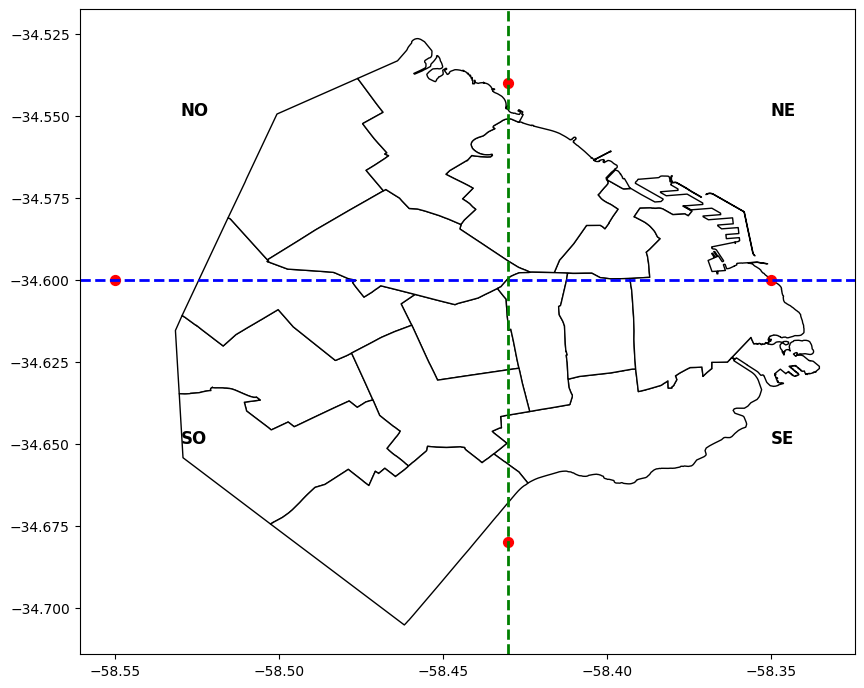

In [6]:
# Create a GeoDataFrame for the 4 quadrant points
data = {'lat': [-34.68, -34.54, -34.6, -34.6],
        'long': [-58.43, -58.43, -58.55, -58.35]}
points_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['long'], data['lat']))


# Plot the map
ax = buenos_aires_map.plot(figsize=(10, 10), edgecolor='black', color='white')

# Plot the points on the map
points_gdf.plot(ax=ax, color='red', marker='o', markersize=50)

# Plot horizontal line at -34.6
ax.axhline(y=-34.6, color='blue', linestyle='--', linewidth=2)

# Plot vertical line at -58.43
ax.axvline(x=-58.43, color='green', linestyle='--', linewidth=2)

# Label the quadrants
ax.text(-58.43 + 0.08, -34.6 + 0.05, 'NE', fontsize=12, fontweight='bold', color='black')
ax.text(-58.43 - 0.1, -34.6 + 0.05, 'NO', fontsize=12, fontweight='bold', color='black')
ax.text(-58.43 + 0.08, -34.6 - 0.05, 'SE', fontsize=12, fontweight='bold', color='black')
ax.text(-58.43 - 0.1, -34.6 - 0.05, 'SO', fontsize=12, fontweight='bold', color='black')

# Show the plot
plt.show()


Además, ploteamos las estaciones sobre el mapa de la ciudad con los cuadrantes. 

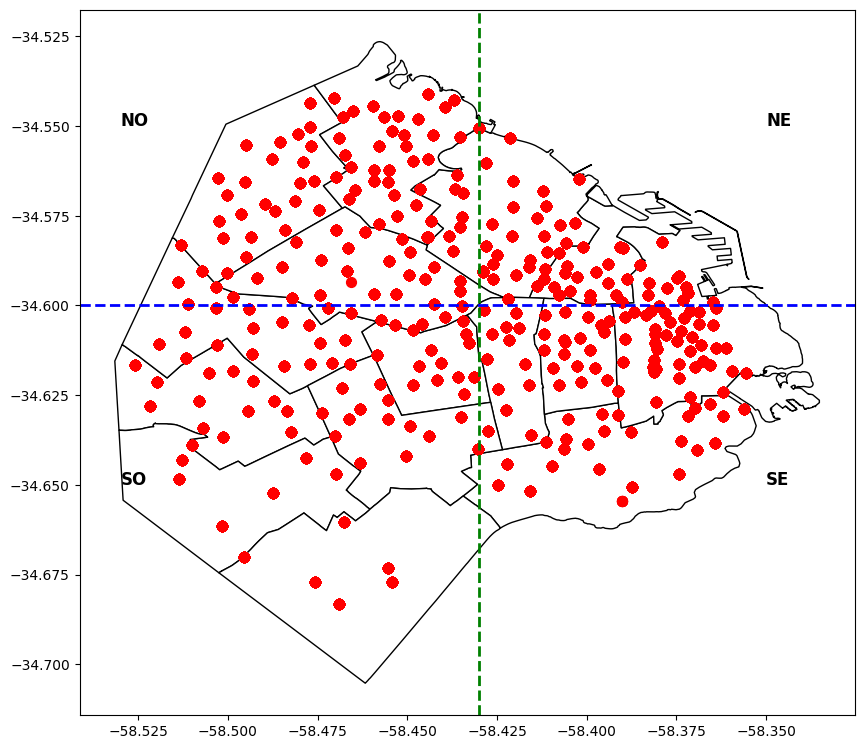

In [7]:
# Plot the origin station points in the quadrants

points_gdf = gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips['long_estacion_origen'], trips['lat_estacion_origen']))

# Plot the map
ax = buenos_aires_map.plot(figsize=(10, 10), edgecolor='black', color='white')

# Plot the points on the map
points_gdf.plot(ax=ax, color='red', marker='o', markersize=50)

# Plot horizontal line at -34.6
ax.axhline(y=-34.6, color='blue', linestyle='--', linewidth=2)

# Plot vertical line at -58.43
ax.axvline(x=-58.43, color='green', linestyle='--', linewidth=2)

# Label the quadrants
ax.text(-58.43 + 0.08, -34.6 + 0.05, 'NE', fontsize=12, fontweight='bold', color='black')
ax.text(-58.43 - 0.1, -34.6 + 0.05, 'NO', fontsize=12, fontweight='bold', color='black')
ax.text(-58.43 + 0.08, -34.6 - 0.05, 'SE', fontsize=12, fontweight='bold', color='black')
ax.text(-58.43 - 0.1, -34.6 - 0.05, 'SO', fontsize=12, fontweight='bold', color='black')

# Show the plot
plt.show()

Agregamos los cuadrantes a cada registro de los viajes. 

In [8]:
from utils.preprocessor import AddQuadrantColumn, DatetimeTransformer, DateFeaturesTransformer, TimeFeaturesTransformer, AverageTempLast7DaysTransformer, RatioTempTransformer, RollingAveragesTransformer, MergeHolidaysTransformer

In [9]:
# Create a pipeline
preprocessing_pipeline = Pipeline([
    ('add_quadrant', AddQuadrantColumn())
])

# Apply the pipeline to your DataFrame
trips_transformed = preprocessing_pipeline.fit_transform(trips)

Los cuadrantes con mayor cantidad de viajes son el SurEste y el NorEste, que son los que comprenden el centro de la ciudad

In [10]:
trips_transformed['quadrant'].value_counts(normalize=True)

SE    0.346260
NE    0.300355
NO    0.208906
SO    0.144480
Name: quadrant, dtype: float64

In [11]:
trips_transformed.head(5)

,Id_recorrido,duracion_recorrido,fecha_origen_recorrido,id_estacion_origen,nombre_estacion_origen,direccion_estacion_origen,long_estacion_origen,lat_estacion_origen,fecha_destino_recorrido,id_estacion_destino,nombre_estacion_destino,direccion_estacion_destino,long_estacion_destino,lat_estacion_destino,id_usuario,modelo_bicicleta,Género,quadrant
0,13267975BAEcobici,"2,610",2022-01-16 14:58:42,5BAEcobici,005 - Plaza Italia,Av. Sarmiento 2601,-58.420954,-34.580550,2022-01-16 15:42:12,210BAEcobici,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,776361BAEcobici,ICONIC,FEMALE,NE
1,13268526BAEcobici,545,2022-01-16 17:26:27,51BAEcobici,051 - TUCUMAN,Tucuman & 9 De Julio Av.,-58.382126,-34.601478,2022-01-16 17:35:32,174BAEcobici,174 - MINISTERIO DE EDUCACION,Marcelo T. de Alvear & Rodriguez Peña,-58.391768,-34.597225,776407BAEcobici,ICONIC,MALE,SE
2,13268400BAEcobici,"2,061",2022-01-16 16:51:12,161BAEcobici,161 - Humahuaca,3912 Humahuaca,-58.419676,-34.602078,2022-01-16 17:25:33,117BAEcobici,117 - HUMBERTO 1°,Peru 1016,-58.374176,-34.620101,671762BAEcobici,ICONIC,FEMALE,SE
3,13268164BAEcobici,"12,748",2022-01-16 15:58:01,210BAEcobici,335 - General Urquiza,Figueroa Alcorta & Sarmiento,-58.411278,-34.572165,2022-01-16 19:30:29,382BAEcobici,204 - Biarritz,Biarritz 2403,-58.477390,-34.605470,776361BAEcobici,ICONIC,FEMALE,NE
4,13270010BAEcobici,"4,337",2022-01-16 23:40:09,215BAEcobici,113 - Guatemala,Guatemala 4773,-58.424996,-34.585878,2022-01-17 00:52:26,205BAEcobici,125 - F.J.Santamaria de Oro,F.J.Santamaria de Oro & Guatemala,-58.428016,-34.583323,454615BAEcobici,ICONIC,OTHER,NE


### Análisis temporal

Preprocesamos las features para extraer información útil (hay más detalle de este punto en la explicación del archivo preprocessing.py)

In [12]:
# Create a pipeline
datetime_pipeline = Pipeline([
    ('datetime_transformer', DatetimeTransformer()),
    ('date_features_transformer', DateFeaturesTransformer()),
    ('time_features_transformer', TimeFeaturesTransformer())
])

# Apply the pipeline to your DataFrame
trips_dt = datetime_pipeline.transform(trips_transformed)

Visualizamos distintos análisis temporales: por mes, por día de la semana, y por día. 

Podemos ver que hay una fuerte estacionalidad anual, y que los días de semana tienen mucha mayor cantidad de viajes que los fines de semana. Algunas hipótesis son que las bicis de la ciudad son principalmente utilizadas como medio de transporte para ir al trabajo, y que el clima en las distintas estaciones del año afecta a la usabilidad.

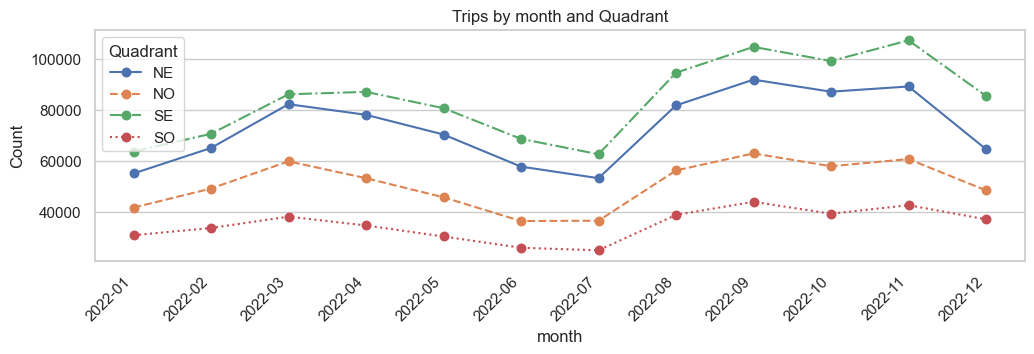

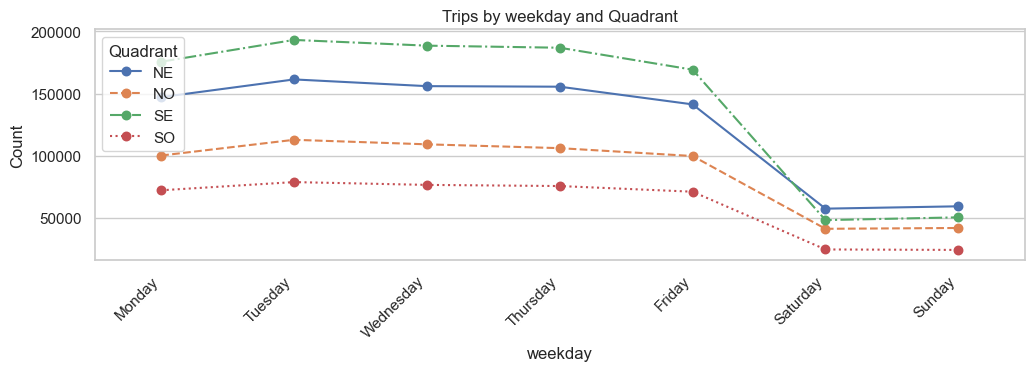

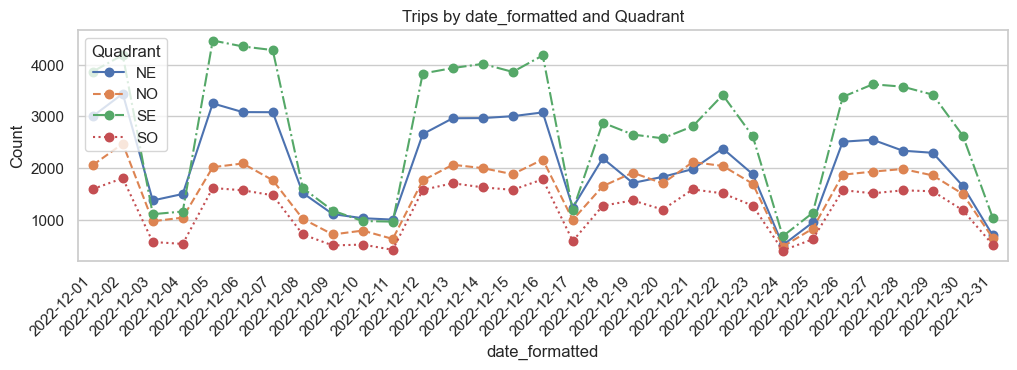

In [13]:
# Exploration - plot trips by month, weekday and day

trips_by_day = trips_dt[['month','date_formatted','quadrant']].value_counts().sort_index().reset_index()
trips_by_month = trips_dt[['month','quadrant']].value_counts().sort_index().reset_index()
trips_by_weekday = trips_dt[['weekday','quadrant']].value_counts().sort_index().reset_index()


def plot_trips_by_period(trips, period, hue=None, linestyles=None, markersize=6):

    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 3))

    sns.pointplot(data=trips, x=period, y=0, hue=hue,linestyles=linestyles,
                markersize=markersize, linewidth=1.5)

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')

    # Add legend
    plt.legend(title='Quadrant', loc='upper left')

    # Set plot title and labels
    plt.title(f'Trips by {period} and Quadrant')
    plt.xlabel(period)
    plt.ylabel('Count')

    # Show the plot
    plt.show()


plot_trips_by_period(trips_by_month, 'month', hue='quadrant', linestyles=["-", "--", "-.", ":"])
plot_trips_by_period(trips_by_weekday, 'weekday', hue='quadrant',linestyles=["-", "--", "-.", ":"])
plot_trips_by_period(trips_by_day[trips_by_day.month=='2022-12'], 'date_formatted', hue='quadrant',linestyles=["-", "--", "-.", ":"])

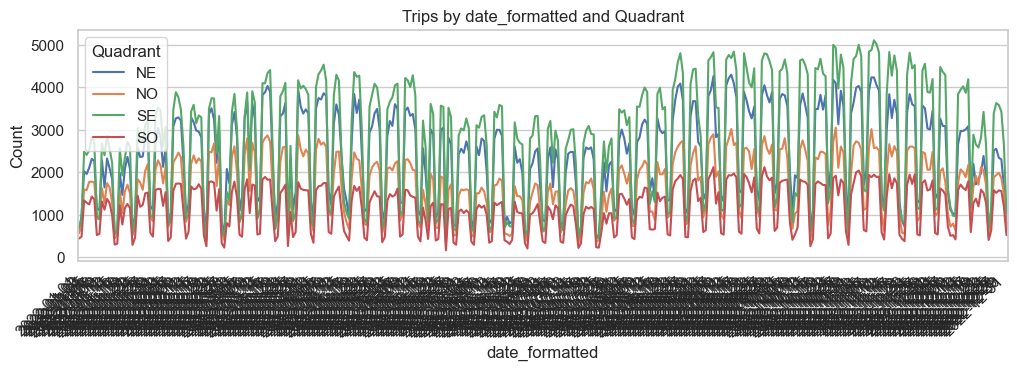

In [14]:
# Graficamos todo el año
plot_trips_by_period(trips_by_day, 'date_formatted', hue='quadrant', markersize=0)


Se agrupa el dataset a nivel día y cuadrante para calcular el total de viajes

In [15]:
# Generate a dataframe with date - quadrant cardinality, to predict trips by quadrant and day

trips_dt_quadrant = trips_dt[['month','date_formatted', 'weekday','is_weekend','quadrant']].value_counts().reset_index().rename(columns={0:'trips'})

### Outliers

Con el análisis más simple de outliers vemos que no hay días donde la cantidad total de viajes salga fuera de los parámetros de 1.5 * Rango Intercuartil.

<Axes: xlabel='quadrant', ylabel='trips'>

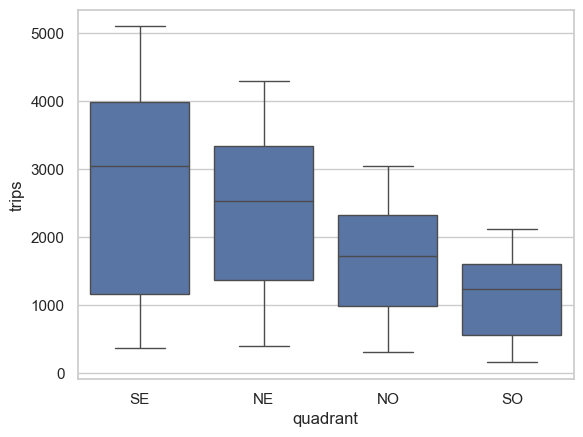

In [16]:
sns.boxplot(trips_dt_quadrant, x='quadrant',y='trips')


Analizando por día de la semana, podemos ver que hay algunos días que sí tienen cantidad de viajes atípicos para ese día. Un ejemplo es el Domingo 18/12/2022, donde la ciudad entera festejó el Mundial ganado, y la cantidad de viajes para un domingo fue muy superior. 


Si bien no se hizo en este proyecto, para una versión posterior sería interesante incorporar información de eventos al modelo.

<Axes: xlabel='weekday', ylabel='0'>

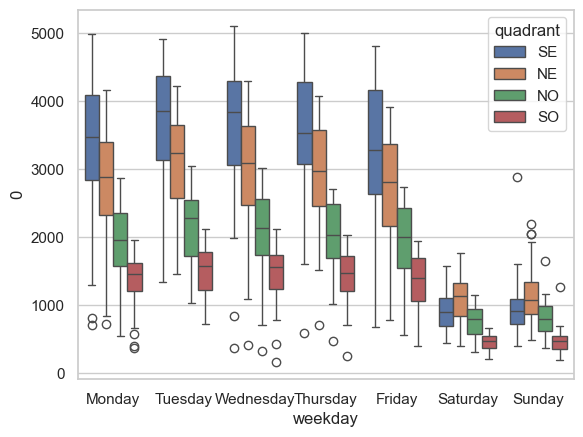

In [17]:
df_plot = trips_dt[['month','date_formatted', 'weekday','is_weekend','quadrant']].value_counts().reset_index()
plt.figure()
sns.boxplot(df_plot, x='weekday',y=0, hue='quadrant')

In [18]:
df_plot[df_plot.weekday=='Sunday'].sort_values(by=0, ascending=False).head(10)

,month,date_formatted,weekday,is_weekend,quadrant,0
346,2022-12,2022-12-18,Sunday,1,SE,2879
571,2022-12,2022-12-18,Sunday,1,NE,2189
609,2022-10,2022-10-23,Sunday,1,NE,2043
610,2022-11,2022-11-06,Sunday,1,NE,2041
652,2022-10,2022-10-09,Sunday,1,NE,1924
679,2022-08,2022-08-14,Sunday,1,NE,1853
736,2022-10,2022-10-02,Sunday,1,NE,1737
778,2022-12,2022-12-18,Sunday,1,NO,1648
799,2022-10,2022-10-23,Sunday,1,SE,1607
847,2022-08,2022-08-14,Sunday,1,SE,1549


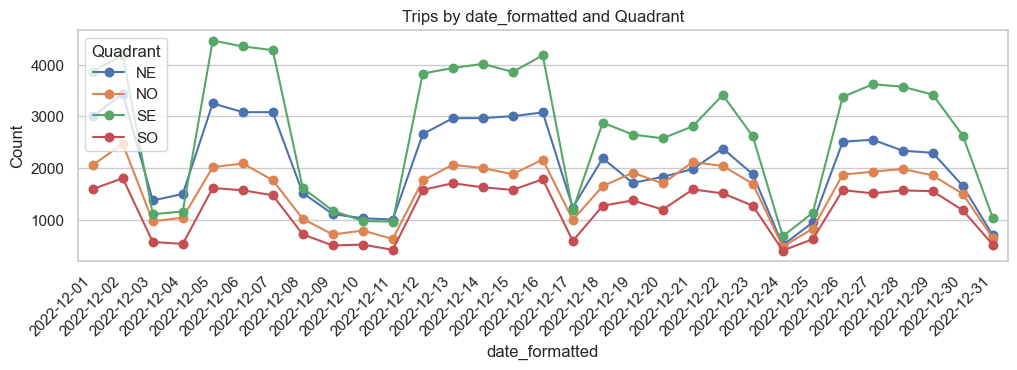

In [19]:
# Se visualiza una cantidad de viajes excesiva para un domingo el 18/12

plot_trips_by_period(trips_by_day[(trips_by_day.month=='2022-12')].sort_values(by='date_formatted'), 'date_formatted', hue='quadrant')

## Nuevas features

### Clima

Se incorpora información de clima para el análisis y el posterior entrenamiento del modelo. Dentro de la información incluida se encuentran temperaturas máximas, mínimas y promedio, y precipitaciones. 

In [20]:
weather = pd.read_csv('weather/open-meteo-34.62S58.41W19m.csv', delimiter=';')
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   time                       365 non-null    object 
 1   weather_code (wmo code)    365 non-null    int64  
 2   temperature_2m_max (°C)    365 non-null    float64
 3   temperature_2m_min (°C)    365 non-null    float64
 4   temperature_2m_mean (°C)   365 non-null    float64
 5   precipitation_sum (mm)     365 non-null    float64
 6   rain_sum (mm)              365 non-null    float64
 7   precipitation_hours (h)    365 non-null    float64
 8   wind_speed_10m_max (km/h)  365 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 25.8+ KB


In [21]:
trips_dt_wht = trips_dt_quadrant.merge(weather, left_on='date_formatted', right_on='time', how='left')

### Promedios móviles

Se agregan features de promedios móviles para la cantidad de viajes, para validar la hipótesis que los viajes de días o semanas anteriores sirven para predecir la demanda de bicis del siguiente día

In [22]:
trips_dt_wht['date'] = pd.to_datetime(trips_dt_wht['date_formatted'])
trips_dt_wht = trips_dt_wht.sort_values(by='date')

# Calculate rolling averages for weekdays - only usings weekdays 

# Partition by quadrant
for quadrant in trips_dt_wht['quadrant'].unique():
    quadrant_mask = trips_dt_wht['quadrant'] == quadrant
    weekday_mask = trips_dt_wht['is_weekend'] == 0

    mask = quadrant_mask & weekday_mask

    # 1. Trips Last Day
    trips_dt_wht.loc[mask, 'trips_last_day'] = trips_dt_wht.loc[mask, 'trips'].shift(1)

    # 2. Average Trips Last Week
    trips_dt_wht.loc[mask, 'avg_trips_last_week'] = trips_dt_wht.loc[mask, 'trips'].shift().rolling(window=7, min_periods=1).mean()

    # 3. Average Trips Last Month
    trips_dt_wht.loc[mask, 'avg_trips_last_month'] = trips_dt_wht.loc[mask, 'trips'].shift().rolling(window=30, min_periods=1).mean()

    # 4. Trips Same Day Last Week
    trips_dt_wht.loc[mask, 'trips_same_day_last_week'] = trips_dt_wht.loc[mask].groupby(trips_dt_wht['date'].dt.weekday)['trips'].shift(7)

# Calculate rolling averages for weekends - only usings weekends 

# Partition by quadrant
for quadrant in trips_dt_wht['quadrant'].unique():
    quadrant_mask = trips_dt_wht['quadrant'] == quadrant
    weekday_mask = trips_dt_wht['is_weekend'] == 1

    mask = quadrant_mask & weekday_mask

    # 1. Trips Last Day
    trips_dt_wht.loc[mask, 'trips_last_day'] = trips_dt_wht.loc[mask, 'trips'].shift(1)

    # 2. Average Trips Last Week
    trips_dt_wht.loc[mask, 'avg_trips_last_week'] = trips_dt_wht.loc[mask, 'trips'].shift().rolling(window=2, min_periods=1).mean()

    # 3. Average Trips Last Month
    trips_dt_wht.loc[mask, 'avg_trips_last_month'] = trips_dt_wht.loc[mask, 'trips'].shift().rolling(window=8, min_periods=1).mean()

    # 4. Trips Same Day Last Week
    trips_dt_wht.loc[mask, 'trips_same_day_last_week'] = trips_dt_wht.loc[mask].groupby(trips_dt_wht['date'].dt.weekday)['trips'].shift(2)



Visualizamos la serie original de viajes junto con el promedio móvil de 1 mes y el desvío. 

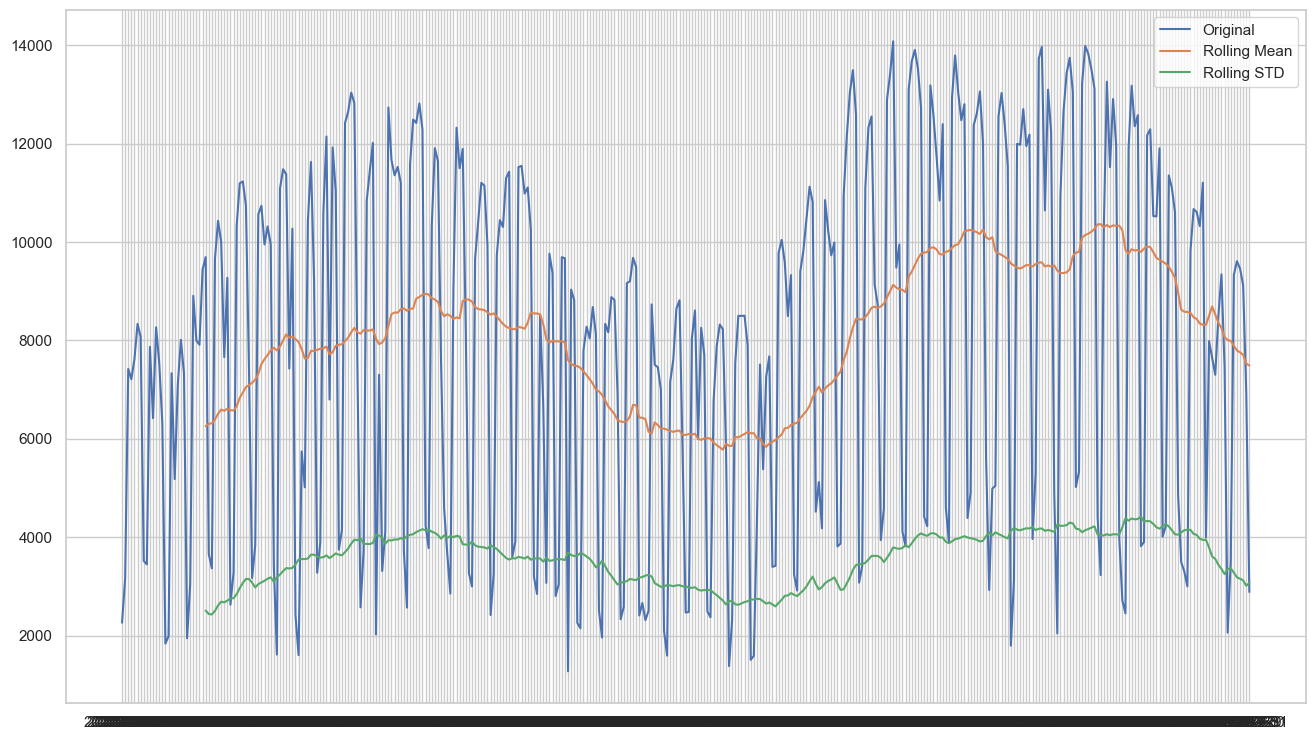

In [23]:
time_series = trips_dt_wht.groupby('date_formatted')[['trips']].sum().sort_index()

# no weekends
time_series_weekday = trips_dt_wht[(trips_dt_wht.is_weekend==0)].groupby('date_formatted')[['trips']].sum().sort_index()
def plot_rolling_mean_and_std(dataframe: pd.DataFrame, window: int) -> None:
    """
    This function plots the dataframes
    rolling mean and rolling standard deviation.
    ---
    Args:
        dataframe (pd.DataFrame): Dataframe contains the timeseries
        window (int): window size
    Returns: None
    """
    df = dataframe.copy()
    # Get Things Rolling
    roll_mean = df.rolling(window=window).mean()
    roll_std = df.rolling(window=window).std()
    
    # Figure
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')
    ax.plot(df, label='Original')
    ax.plot(roll_mean, label='Rolling Mean')
    ax.plot(roll_std,  label='Rolling STD')
    
    # Legend & Grid
    ax.legend(loc='upper right')
    # plt.grid(linestyle=":", color='grey')
    plt.show()


# Plot trips and rolling mean only for weekdays

plot_rolling_mean_and_std(time_series, window=28)

### Feriados

Se utiliza la librería holidays para incorporar información de feriados

In [24]:
import pandas as pd
import holidays

ar_holidays = holidays.Argentina(years=2022)
ar_holidays = pd.DataFrame(ar_holidays.items(), columns=['Date', 'Holiday'])

ar_holidays['Date'] = ar_holidays['Date'].astype('str')
ar_holidays

,Date,Holiday
0,2022-01-01,Año Nuevo
1,2022-02-28,Día de Carnaval
2,2022-03-01,Día de Carnaval
3,2022-03-24,Día Nacional de la Memoria por la Verdad y la ...
4,2022-04-02,Día del Veterano y de los Caidos en la Guerra ...
5,2022-04-15,Viernes Santo
6,2022-05-01,Día del Trabajo
7,2022-05-25,Día de la Revolución de Mayo
8,2022-06-20,Paso a la Inmortalidad del General Don Manuel ...
9,2022-07-09,Día de la Independencia


In [25]:
trips_dt_wht_hol = trips_dt_wht.merge(ar_holidays, left_on='date_formatted', right_on='Date', how='left')
trips_dt_wht_hol['is_holiday'] = trips_dt_wht_hol['Holiday'].notnull().astype('int')

### Correlaciones

Realizando un análisis de correlaciones vemos las siguientes relaciones principales:
- Fin de semana, feriado y precipitación son los factore que impactan de forma negativa en la cantidad de viajes
- Los promedios de viajes en los días y semanas anteriores están fuertemente correlacionados con la cantidad de viajes.


Podemos intuir entonces que lo más relevante para predecir la cantidad de viajes, es la serie de tiempo propia de los viajes, diferenciando los fines de semana y feriados, y que la información de precipitaciones y temperatura nos va a ayudar a tener una predicción más aproximada. 

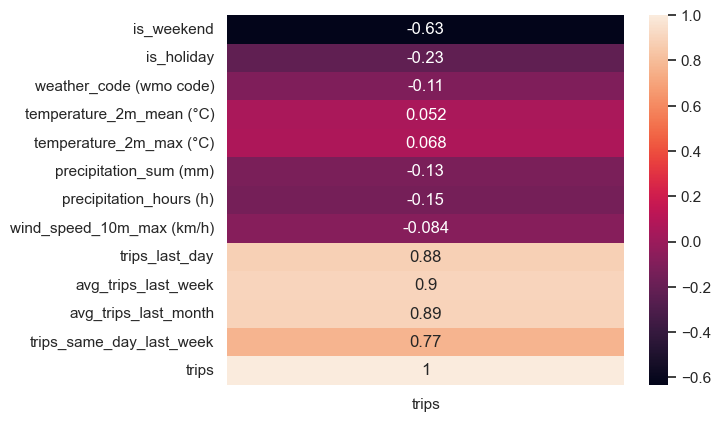

In [26]:
selected_variables = ['weekday', 'is_weekend', 'is_holiday',
                                    'weather_code (wmo code)', 'temperature_2m_mean (°C)', 
                                    'temperature_2m_max (°C)', 'precipitation_sum (mm)', 
                                    'precipitation_hours (h)', 'wind_speed_10m_max (km/h)', 
                                    'trips_last_day', 'avg_trips_last_week', 'avg_trips_last_month', 'trips_same_day_last_week']

correlation_matrix = trips_dt_wht_hol[[*selected_variables,
                                    'trips']].corr()
sns.heatmap(correlation_matrix[['trips']], annot=True);

Dada la diferencia tan grande entre días de semana y fin de semana, analizamos las correlaciones y vemos que se incrementan los efectos de las variables de clima. 

<Axes: >

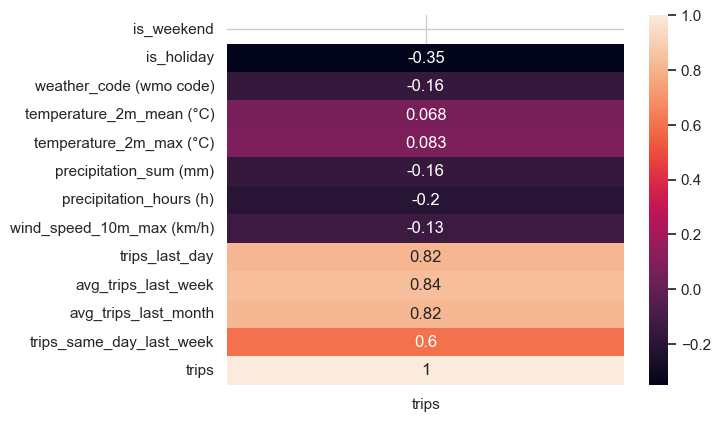

In [27]:
# Correlations weekdays
correlation_matrix = trips_dt_wht_hol.loc[trips_dt_wht_hol.is_weekend==0, 
                                      [*selected_variables, 'trips']].corr()
sns.heatmap(correlation_matrix[['trips']], annot=True)